# <center>GBDT</center>

## 一、引言 

　　GBDT(Gradient Boosting Decision Tree) 是一种迭代的决策树算法,又叫MART (Multiple Additive Regression Tree),它通过构造一组弱的学习器(树),并把多颗决策树的结果累加起来作为最终的预测输出.该算法将决策树与集成学习进行了有效的结合.

　　GBDT的思想使其具有天然优势可以发现多种有区分性的特征以及特征组合.自算法的诞生之初,它就和SVM一起被认为是泛化能力(geteralization)较强的算法.近些年来更因为被用于构建搜索排序的机器学习模型而引起广泛的关注.它最早见于yahoo,后被广泛应用于搜索排序、点击率预估上.业界中,Facebook使用其来自动发现有效的特征、特征组合,来作为LR模型中的特征,以提高CTR预估(Click-Through Rate Prediction)的准确性;GBDT在淘宝的搜索及预测业务上也发挥了重要作用.

　　本文首先介绍GBDT中的DT,即回归树,这是它的基础算法;然后叙述提升树,它是以决策树为基函数的提升方法;接着介绍GBDT中的GB,即梯度提升;最后导出GBDT算法的整个流程.

## 二、Regression Decision Tree: 回归树

### 2.1 回归树简介

　　树模型也分为决策树和回归树,决策树常用于分类问题,回归树常用于预测问题.决策树常用于分类标签值,比如用于性别、网页是否是垃圾页面、用户是不是作弊;而回归树常用于预测真实数值,比如用户的年龄、用户点击的概率、网页相关程度等等.

　　回归树总体流程类似于分类树,区别在于,回归树的每一个节点都会得到一个预测值,以年龄为例,该预测值等于属于这个节点的所有人年龄的平均值.分枝时穷举每一个feature的每个阈值寻找最优切分变量和最优切分点,但衡量的准则不再是分类树中的基尼系数,而是平方误差最小化.也就是被预测错误的人数越多,平方误差就越大,通过最小化平方误差找到最可靠的分枝依据.分枝知道每个叶子节点上人的年龄都唯一或者达到预设的终止条件(如叶子个数上限),若最终叶子节点上人的年龄不唯一,则以该节点上所有人的平均年龄做为该叶子节点的预测年龄.

　　由于GBDT的核心在于累加所有树的结果做为最终结果,而分类树得到的离散分类结果对于预测分类并不是这么的容易叠加(稍等后面会看到,其实并不是简单的叠加,而是每一步每一棵树的残差和悬着分裂点评价方式都经过公式推导得到的),而对于基于回归树所得到的数值进行加减是有意义的(例如10岁+5岁-3岁=12岁),这是区别分类树的一个显著特征(毕竟男+女=是男是女?这样的运算是毫无道理的),GBDT在运行时使用到了回归树的这个性质,它将累加所有树的结果作为最终结果.所以GBDT中的树都是回归树,而不是分类树,它用来做回归预测,当然回归树经过调整之后也能用来做分类.

### 2.2 回归树的生成

首先看一个简单的回归树生成实例:

/home/xiagte/opt/bin/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


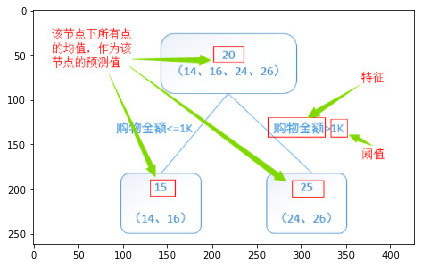

In [2]:
from skimage import io
img=io.imread('./GBDT.jpg')
io.imshow(img)

　　接下来具体说说回归树是如何进行特征选择生成二叉回归树的.

　　假设X与Y分别为输入和输出变量,并且Y是连续变量,给定训练数据集

$$D=\{(x_1,y_1),(x_2,y_2),\cdots,(x_N,y_N)\}$$

　　我们利用最小二乘回归树生成算法来生成回归树$f(x)$,即在训练数据集所在的输入空间中,递归地将每个区域分为两个子区域并决定每个子区域上的输出值,构建二叉决策树,步骤如下:

- 1) 选择最优切分变量j与切分点s,求解:

$$\min_{j,s}[\min_{c_1} \sum_{x_i \in R_1(j,s)}(y_i-c_1)^2 + \min_{c_2}\sum_{x_i \in R_2(j,s)}(y_i-c_i)^2]$$

　　遍历变量j,对固定的切分变量$j$扫描切分点s,选择使上式达到最小值的对$j,s$

- 2) 用选定的对$(j,s)$划分区域并决定相应的输出值:

$$R_1(j,s)=\{x|x^{(j)} \leq s\}\ ,\ R_2(j,s)=\{x|x^{(j)} > s\}$$

$$\hat c_m=\frac{1}{N_m}\sum_{x_i \in R_2(j,s)}y_i\ ,\ x \in R_m\ ,\ m=1,2$$

- 3) 继续对两个子区域调用步骤(1),(2)直至满足停止条件

- 4) 将输入空间划分为$M$个区域$R_1,R_2,\cdots,R_M$,在每个单元$R_m$上有一个固定的输出值$c_m$,生成决策树:

$$f(x)=\sum_{m=1}^M \hat c_m I(x \in R_m)$$

## Boosting Decsion Tree: 提升树